In [1]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import wandb

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
from pytorch_lightning.loggers import WandbLogger

from helpers.datasets import *
from helpers.models import *

from datetime import date

In [2]:
wandb_logger = WandbLogger(project="Feta-toy-example")
SEED = 8
DATE = date.today()

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # pick a number < 4 
# selecting appropriate device
CUDA = torch.cuda.is_available()
print("cuda available:", CUDA)
device = torch.device("cuda" if CUDA else "cpu")

cuda available: True


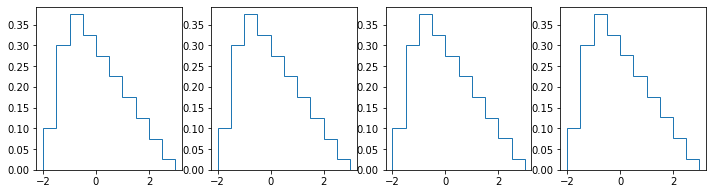

In [7]:
# Dataset

dim_data = int(4)
dim_context = int(1)
num_train = int(1e6)
num_val = int(1e5)

my_data = ToyDataModuleLit(dim_data, dim_context, num_train, num_val)

fig, ax = plt.subplots(1, 4, figsize = (12, 3))
for i in range(4):
    ax[i].hist(my_data.train_data[:,i], histtype = "step", density = True)
    
fig.show()

In [10]:
# flow model

flow_args = {"num_layers":2, "num_nodes": 32, "num_blocks":10, "num_bins":8}
lr = 1e-3
wd = 1e-3

my_flow = BaseDensityLit(dim_data, dim_context, flow_args, lr, wd)


In [14]:
# checkpoints and process bar

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints/{}/{}/".format(DATE, SEED),
    filename="hhh".format(DATE.today())
    + "{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
)


progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="pretty_pink",
        progress_bar="#ffa3f0",
        progress_bar_finished="#eb15c7",
        progress_bar_pulse="##520545",
        batch_progress="pretty_pink",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82",
    )
)



In [ ]:
# train

pl.seed_everything(SEED, workers=True)
trainer = pl.Trainer(limit_train_batches = 100, max_epochs=10, logger = wandb_logger, gpus = 1,
                      callbacks=[checkpoint_callback, progress_bar])
                    #accelerator="gpu", devices=2, strategy="ddp")
trainer.fit(my_flow, my_data)

Global seed set to 8
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type               ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ base_dist │ StandardNormal     │      0 │
│ 1 │ transform │ CompositeTransform │ 50.0 K │
│ 2 │ flow      │ Flow               │ 50.0 K │
└───┴───────────┴────────────────────┴────────┘

Trainable params: 50.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 50.0 K                                                                                               
Total estimated model params size (MB): 0

Output()

Global seed set to 8


In [ ]:
# check training

with torch.no_grad():
    outputs, logabsdet = my_flow.flow._transform.inverse(torch.tensor((my_data.valid_data).float(), 
                                                         context=torch.tensor((my_data.valid_context).float())

print(type(outputs))
outputs = outputs.numpy()

fig, ax = plt.subplots(1, 4, figsize = (12, 3))
for i in range(4):
    ax[i].hist(my_data.valid_data[:,i], histyype = "step")
    ax[i].hist(outputs[:,i], histyype = "step")
    
fig.show()